In [ ]:
!pip install kneed

In [59]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

# Basic configuration
DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [ ]:
price_matrix, symbols = load_and_prepare_data('./nasdaq_daily.parquet')


$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [ ]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [ ]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [ ]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [ ]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

# K-Means

##### Find Number of Clusters

In [ ]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

##### Build Cluster

In [ ]:
c = 5
#Fit the model
k_means = KMeans(n_clusters=c, random_state=42, n_init=10, init='random')  # gleiche Parameter wie vorher
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=10)
plt.show()

#### Number auf Stock Pairs per Cluster

In [ ]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

# Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

plt.axhline(y=6, color='purple', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
clusters = 4
hc = AgglomerativeClustering(n_clusters=clusters)
labels = hc.fit_predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Affinity Propagation Clustering

In [ ]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [ ]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [ ]:
from sklearn import metrics

print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

In [ ]:
# Erstelle Series mit den Labels aus Affinity Propagation
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

# Berechne die Cluster-Größen mit den gleichen Einschränkungen
cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

In [51]:
def find_cointegrated_pairs(price_matrix, pvalue_threshold=0.05):
    n = price_matrix.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    symbols = price_matrix.columns
    pairs = []
    results = []
    
    total_pairs = sum(range(n))
    with tqdm(total=total_pairs, desc="Analyzing pairs") as pbar:
        for i in range(n):
            for j in range(i+1, n):
                S1 = price_matrix[symbols[i]]
                S2 = price_matrix[symbols[j]]
                
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                
                results.append({
                    'symbol1': symbols[i],
                    'symbol2': symbols[j],
                    'p_value': pvalue,
                    'score': score
                })
                
                if pvalue <= pvalue_threshold:
                    pairs.append((symbols[i], symbols[j]))
                    
                pbar.update(1)
    
    return score_matrix, pvalue_matrix, pairs, results

def analyze_pairs(price_matrix, pvalue_threshold=0.05):
    """
    Runs the cointegration analysis and prints summary
    """
    score_matrix, pvalue_matrix, pairs, results = find_cointegrated_pairs(
        price_matrix, 
        pvalue_threshold
    )
    
    print(f"\nAnalysis complete!")
    print(f"Found {len(pairs)} cointegrated pairs")
    print(f"Total pairs analyzed: {len(results)}")
    
    summary_df = pd.DataFrame(results)
    summary_df['is_cointegrated'] = summary_df['p_value'] <= pvalue_threshold
    
    return score_matrix, pvalue_matrix, pairs, summary_df

def plot_cointegration_heatmap(pvalue_matrix, symbols, max_pvalue=0.98):
    """
    Creates a heatmap visualization of the cointegration p-values
    """
    plt.figure(figsize=(12, 8))
    mask = (pvalue_matrix >= max_pvalue)
    
    sns.heatmap(
        pvalue_matrix, 
        xticklabels=symbols, 
        yticklabels=symbols, 
        cmap='RdYlGn_r',
        mask=mask
    )
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('Cointegration p-values heatmap')
    plt.tight_layout()
    plt.show()

Analyzing pairs: 100%|██████████| 78/78 [00:01<00:00, 75.54it/s]



Analysis complete!
Found 6 cointegrated pairs
Total pairs analyzed: 78

Cluster 0 pairs:
ADSK - TTWO
AMZN - TTWO
ANSS - TTWO
ANSS - WDAY
CSGP - MCHP
TTWO - WDAY


Analyzing pairs: 100%|██████████| 171/171 [00:02<00:00, 80.41it/s]



Analysis complete!
Found 20 cointegrated pairs
Total pairs analyzed: 171

Cluster 1 pairs:
CDW - KDP
CDW - XEL
CSX - CTSH
CSX - EA
CSX - EXC
CSX - KDP
CSX - KHC
CSX - ROP
CSX - XEL
EA - EXC
EA - HON
EA - PEP
EA - ROP
EA - TXN
EXC - HON
HON - PEP
HON - TXN
KDP - MNST
KDP - ROP
KHC - ROP


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 77.30it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 10

Cluster 2 pairs:
AVGO - AXON


Analyzing pairs: 100%|██████████| 91/91 [00:01<00:00, 78.55it/s]



Analysis complete!
Found 7 cointegrated pairs
Total pairs analyzed: 91

Cluster 3 pairs:
CDNS - CPRT
CDNS - ORLY
GOOG - GOOGL
GOOG - TSM
GOOGL - TSM
ISRG - TSM
ODFL - SNPS


Analyzing pairs: 100%|██████████| 1/1 [00:00<00:00, 73.86it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 1


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 72.53it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 10


Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 81.03it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 36


Analyzing pairs: 100%|██████████| 120/120 [00:01<00:00, 80.49it/s]



Analysis complete!
Found 10 cointegrated pairs
Total pairs analyzed: 120

Cluster 9 pairs:
ADI - CCEP
ADI - CTAS
ADI - LIN
ADI - MSFT
ADI - VRSK
ADP - TMUS
FAST - MSFT
LIN - PCAR
MSFT - VRSK
REGN - VRTX


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 80.47it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 10


Analyzing pairs: 100%|██████████| 6/6 [00:00<00:00, 79.95it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 6

Cluster 11 pairs:
MRVL - TTD


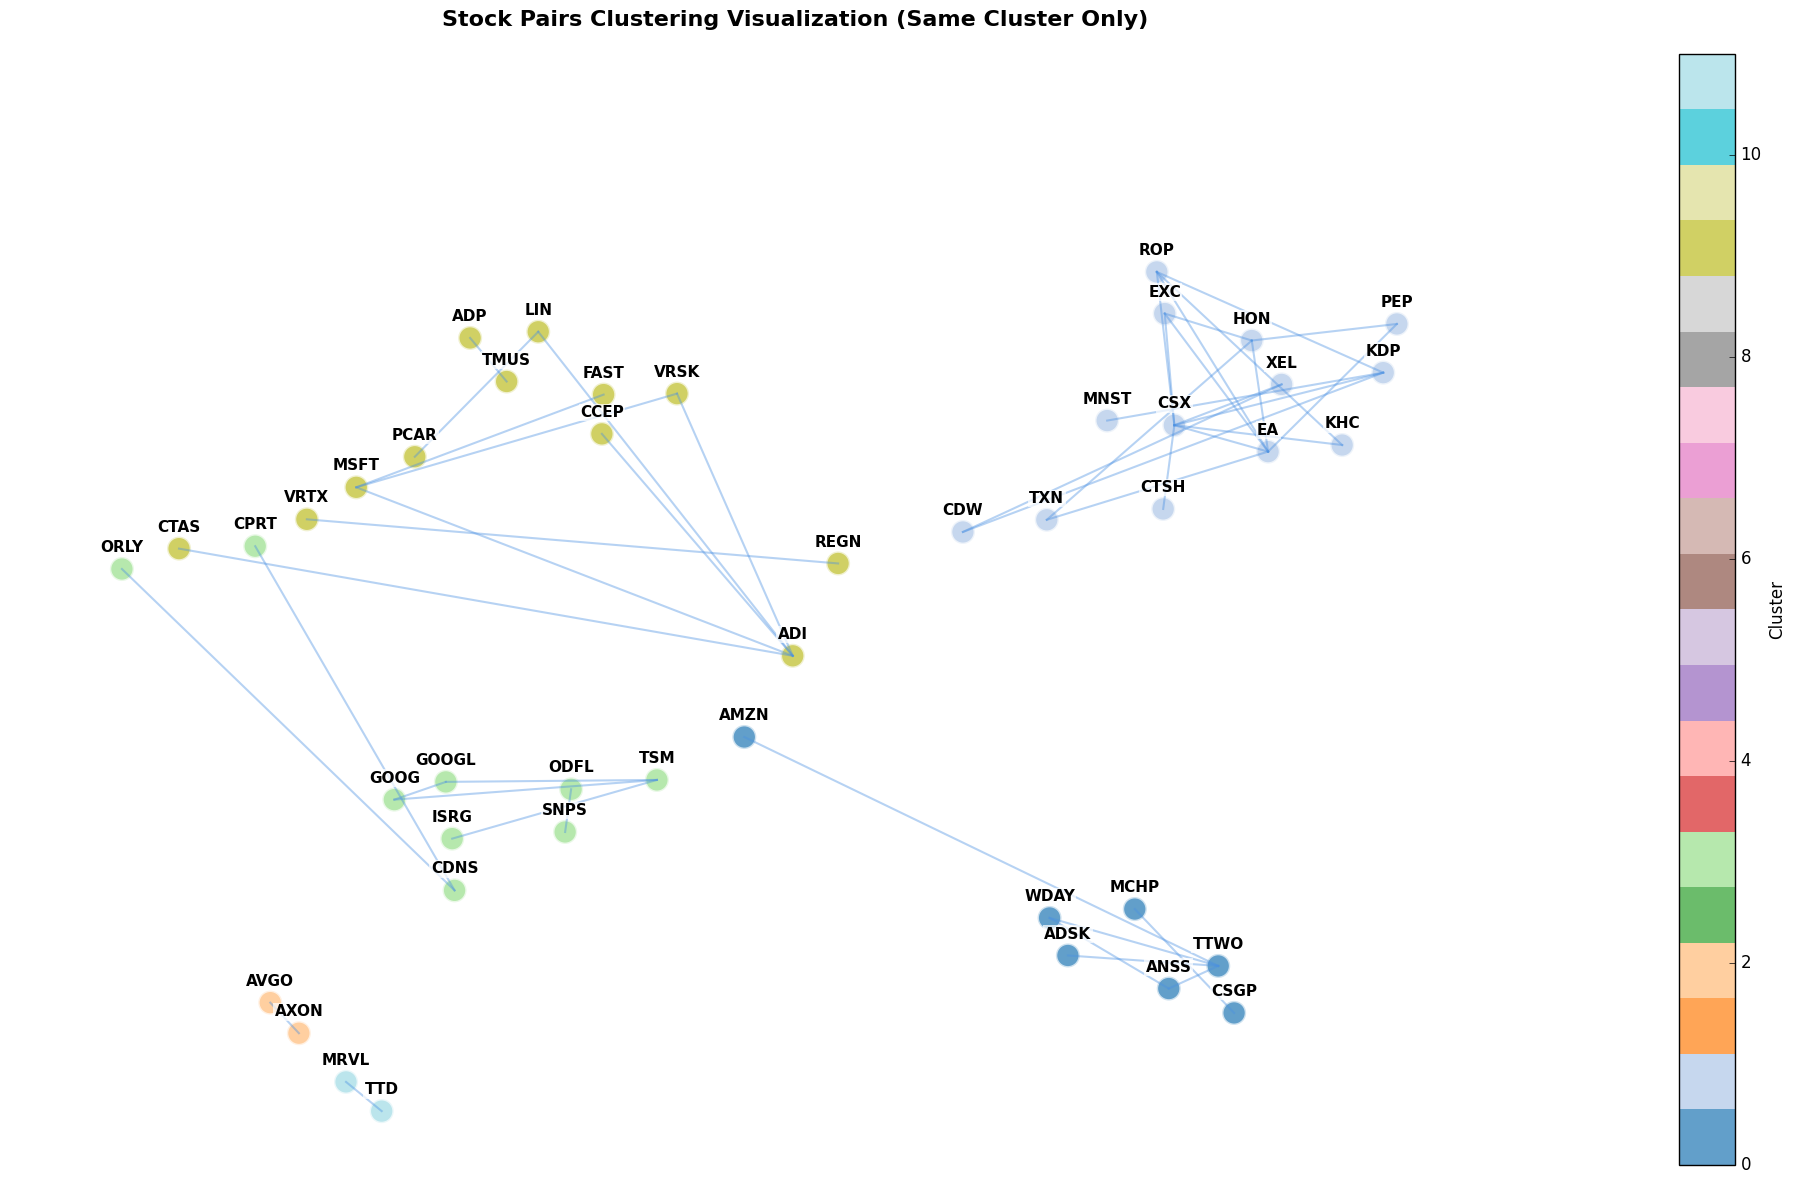

In [ ]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=0.01
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [ ]:
stocks = np.unique(all_pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
stocks = list(np.unique(all_pairs))
X_pairs = X_data.T.loc[stocks]

In [ ]:

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

In [ ]:

plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

# Zeichne Linien nur zwischen Paaren aus dem gleichen Cluster
for item in all_pairs_with_clusters:
    pair = item['pair']
    cluster = item['cluster']
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='#4a90e2')

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     c=in_pairs_series.values,
                     cmap='tab20',
                     edgecolor='white',
                     linewidth=2)

for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.7,
                         pad=1))

plt.title('Stock Pairs Clustering Visualization (Same Cluster Only)', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.axis('off')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()